In [22]:
import sys
import os

# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import pandas as pd
import numpy as np 
from utils.utilities_DL import get_DataSet_and_invalid_dates,get_MultiModel_loss_args_emb_opts,load_init_trainer,match_period_coverage_with_netmob
from trainer import MultiModelTrainer, Trainer
from K_fold_validation.K_fold_validation import KFoldSplitter
from constants.config import get_args,update_modif
from utils.save_results import build_results_df
from constants.paths import folder_path,file_name
from plotting.plotting import plot_k_fold_split

trial_id = ''
# ==== GET PARAMETERS ====
model_name ='DCRNN' #'MTGNN' # 'STGCN'  #'CNN' # 
args = get_args(model_name)

# Modification :
args.epochs = 2
args.W = 0
args.K_fold = 5   # Means we will use the first fold for the Ray Tuning and the 4 other ones to get the metrics
args.ray = False
args.loss_function_type = 'quantile'  #'MSE' #

update_modif(args)

coverage = match_period_coverage_with_netmob(file_name)

# Choose DataSet and VisionModel if needed: 
dataset_names = ['subway_in'] # ['calendar','netmob'] #['subway_in','netmob','calendar']
vision_model_name = 'FeatureExtractor_ResNetInspired'  # 'ImageAvgPooling'  #'FeatureExtractor_ResNetInspired' #'MinimalFeatureExtractor',

Model: DCRNN, K_fold = 5
!!! Loss function: quantile 


# Sliding Window Cross Validation 
## Define fixed Dataset K_fold split for each trial: 

In [23]:
folds = list(np.arange(args.K_fold))
K_fold_splitter = KFoldSplitter(dataset_names,args,coverage,folder_path,file_name,vision_model_name,folds)
K_subway_ds,dic_class2rpz = K_fold_splitter.split_k_fold()

Time-step per hour: 4.0
coverage period: 2019-03-16 00:00:00 - 2019-05-31 23:45:00

Init Subway-In Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 


U size:  torch.Size([6719, 40, 7]) Utarget size:  torch.Size([6719, 40, 1])
U_train size:  torch.Size([3912, 40, 7]) Utarget_train size:  torch.Size([3912, 40, 1])
U_valid size:  torch.Size([1304, 40, 7]) Utarget_valid size:  torch.Size([1304, 40, 1])
U_test size:  torch.Size([1310, 40, 7]) Utarget_test size:  torch.Size([1310, 40, 1])
U_train min:  tensor(0.) U_train max:  tensor(10798.)
U_valid min:  tensor(0.) U_valid max:  tensor(1405.)
U_test min:  tensor(0.) U_test max:  tensor(1760.)

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor

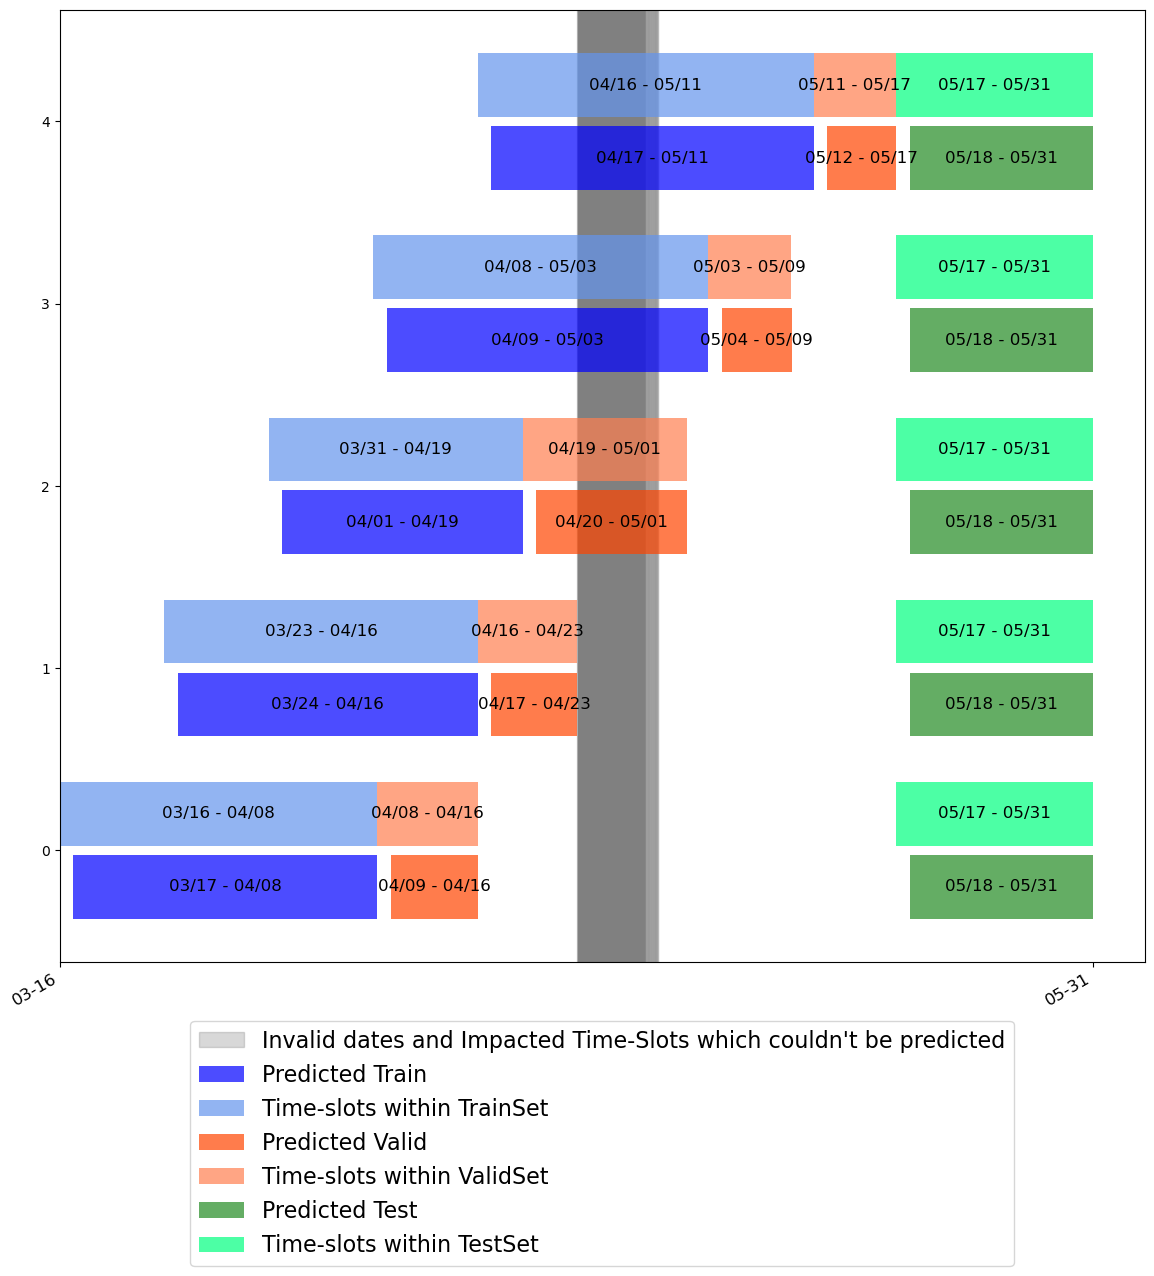

In [24]:
from plotting.plotting import plot_k_fold_split
plot_k_fold_split(K_subway_ds,K_subway_ds[0].init_invalid_dates)

## Split Tuning and Validation datasets:

In [25]:
ds_tuning = K_subway_ds[0]
ds_validation = K_subway_ds[1:]

## Train on the K-1 folds:

In [26]:
from trainer import Trainer
from high_level_DL_method import load_model,load_optimizer_and_scheduler
import numpy as np 
valid_losses = []
for fold,ds in enumerate(ds_validation):
    model = load_model(args,dic_class2rpz)
    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args)
    trainer = Trainer(ds,model,args,optimizer,loss_function,scheduler = scheduler,dic_class2rpz = dic_class2rpz,show_figure = False,fold=fold,save_folder = 'K_fold_validation')
    trainer.train_and_valid(mod = 1000,mod_plot = None) 
    valid_losses.append(trainer.performance['valid_loss'])

row = {f"fold{k}": [loss] for k,loss in enumerate(valid_losses)}
row.update({'mean' : [np.mean(valid_losses)]})
df_results = pd.DataFrame.from_dict(row)
df_results.to_csv(f"{trial_id}.csv")


Model size: 0.000GB
number of total parameters: 4
number of trainable parameters: 4

start training


/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/Users/romainrochas/opt/anaconda3/envs/preprocessingclone/lib/python3.7/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch: 0 
 min\epoch : 0.01
Estimated time for training: 0.0min 
Training Throughput:3306.54 sequences per seconds
>>> Training complete in: 0:00:01.720415
>>> Training performance time: min 0.008780956268310547 avg 0.009562969207763672 seconds (+/- 0.00029113772902955007)
>>> Loading performance time: min 0.00015401840209960938 avg 0.006341239985297708 seconds (+/- 0.016797800920199866)
>>> Forward performance time: 0.004911380343967014 seconds (+/- 0.00021040234479516976)
>>> Backward performance time: 0.004641924964057075 seconds (+/- 0.0001822722386736451)
>>> Plotting performance time: 7.82012939453125e-05 seconds (+/- 0.0)
>>> Saving performance time: 0.0016155242919921875 seconds (+/- 0.00016355514526367188)
>>> PI-tracking performance time: 2.6226043701171875e-06 seconds (+/- 0.0)
>>> Scheduler-update performance time: 3.600120544433594e-05 seconds (+/- 0.0)
>>> Validation time: 0:00:00.165752
Proportion of time consumed for Loading: 39.7%
Proportion of time consumed for Forwar